In [19]:
from IPython.display import Image

# Part 2 - Model Training

This tutorial shows how to implement image recognition task using convolution network with CNTK v2 Python API. You will do this with a basic feedforward CNN architecture to classify [CIFAR dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The CNTK tutorials on GitHub have more advanced networks that are useful for achieving higher accuracy.

[convolution network]:https://en.wikipedia.org/wiki/Convolutional_neural_network

## Introduction

In this tutorial, you will practice the following:

* Understanding subset of CNTK python API needed for image classification task.
* Write a custom convolution network to classify CIFAR dataset.
* Modifying the network structure by adding:
 * [Dropout][] layer.
 * Batchnormalization layer.

[RESNET network]:https://docs.microsoft.com/en-us/cognitive-toolkit/Hands-On-Labs-Image-Recognition 
[Dropout]:https://en.wikipedia.org/wiki/Dropout_(neural_networks)

## Prerequisites

Please run the data loader notebook.


## Dataset

You will use CIFAR 10 dataset, from https://www.cs.toronto.edu/~kriz/cifar.html, during this tutorial. The dataset  contains 50000 training images and 10000 test images, all images are 32 x 32 x 3. Each image is classified as one of 10 classes as shown below:

In [20]:
# Figure 1
Image(url="https://cntk.ai/jup/201/cifar-10.png", width=500, height=500)

The above image is from: https://www.cs.toronto.edu/~kriz/cifar.html

## Convolution Neural Network (CNN)

Here is a brief recap of Convolution Neural Network (CNN). CNN is a feedforward network comprise of a bunch of layers in such a way that the output of one layer is fed to the next layer (There are more complex architecture that skip layers, we will discuss one of those at the end of this lab). Usually, CNN start with alternating between convolution layer and pooling layer (downsample), then end up with fully connected layer for the classification part.

### Convolution layer

Convolution layer consist of multiple 2D convolution kernels applied on the input image or the previous layer, each convolution kernel outputs a feature map.

In [21]:
# Figure 2
Image(url="https://cntk.ai/jup/201/Conv2D.png")

The stack of feature maps output are the input to the next layer.

In [22]:
# Figure 3
Image(url="https://cntk.ai/jup/201/Conv2DFeatures.png")

> Gradient-Based Learning Applied to Document Recognition, Proceedings of the IEEE, 86(11):2278-2324, November 1998
> Y. LeCun, L. Bottou, Y. Bengio and P. Haffner

**In CNTK**:

Here the [convolution][] layer in Python:

```python
def Convolution(filter_shape,        # e.g. (3,3)
                num_filters,         # e.g. 64
                activation,          # relu or None...etc.
                init,                # Random initialization
                pad,                 # True or False
                strides)             # strides e.g. (1,1)
```

[convolution]:https://www.cntk.ai/pythondocs/layerref.html#convolution

### Pooling layer

In most CNN vision architecture, each convolution layer is succeeded by a pooling layer, so they keep alternating until the fully connected layer. 

The purpose of the pooling layer is as follow:

* Reduce the dimensionality of the previous layer, which speed up the network.
* Provide a limited translation invariant.

Here an example of max pooling with a stride of 2:

In [23]:
# Figure 4
Image(url="https://cntk.ai/jup/201/MaxPooling.png", width=400, height=400)

**In CNTK**:

Here the [pooling][] layer in Python:

```python

# Max pooling
def MaxPooling(filter_shape,  # e.g. (3,3)
               strides,       # (2,2)
               pad)           # True or False

# Average pooling
def AveragePooling(filter_shape,  # e.g. (3,3)
                   strides,       # (2,2)
                   pad)           # True or False
```

[pooling]:https://www.cntk.ai/pythondocs/layerref.html#maxpooling-averagepooling

### Dropout layer

Dropout layer takes a probability value as an input, the value is called the dropout rate. Let us say the dropout rate is 0.5, what this layer does it pick at random 50% of the nodes from the previous layer and drop them out of the network. This behavior help regularize the network.

> Dropout: A Simple Way to Prevent Neural Networks from Overfitting
> Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov


**In CNTK**:

Dropout layer in Python:

```python

# Dropout
def Dropout(prob)    # dropout rate e.g. 0.5
```

### Batch normalization (BN)

Batch normalization is a way to make the input to each layer has zero mean and unit variance. BN help the network converge faster and keep the input of each layer around zero. BN has two learnable parameters called gamma and beta, the purpose of those parameters is for the network to decide for itself if the normalized input is what is best or the raw input.

> Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
> Sergey Ioffe, Christian Szegedy

**In CNTK**:

[Batch normalization][] layer in Python:

```python

# Batch normalization
def BatchNormalization(map_rank)  # For image map_rank=1
```

[Batch normalization]:https://www.cntk.ai/pythondocs/layerref.html#batchnormalization-layernormalization-stabilizer


Let us begin by first importing the modules.

In [24]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import PIL
import sys
try: 
    from urllib.request import urlopen 
except ImportError: 
    from urllib import urlopen

import cntk as C

In the block below we select the first GPU device to run on. This allows multiple CNTK sessions (from different users) to simultaneously use the same GPU. If you're running this on your own, you can comment this line out.

In [25]:
C.device.try_set_default_device(C.device.gpu(0))

True

## Data reading

To train the above model we need two things:
* Read the training images and their corresponding labels.
* Define a cost function, compute the cost for each mini-batch and update the model weights according to the cost value.

To read the data in CNTK, we will use CNTK readers which handle data augmentation and can fetch data in parallel.

Example of a map text file:

    S:\data\CIFAR-10\train\00001.png	9
    S:\data\CIFAR-10\train\00002.png	9
    S:\data\CIFAR-10\train\00003.png	4
    S:\data\CIFAR-10\train\00004.png	1
    S:\data\CIFAR-10\train\00005.png	1


In [26]:
# data_path = os.path.join('data', 'CIFAR-10')
data_path = '.'

# model dimensions
image_height = 32
image_width  = 32
num_channels = 3
num_classes  = 10

import cntk.io.transforms as xforms 
#
# Define the reader for both training and evaluation action.
#
def create_reader(map_file, mean_file, train):
    print("Reading map file:", map_file)
    print("Reading mean file:", mean_file)
    
    if not os.path.exists(map_file) or not os.path.exists(mean_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    # train uses data augmentation (translation only)
    if train:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8) 
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        xforms.mean(mean_file)
    ]
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

In [27]:
# Create the train and test readers
reader_train = create_reader(os.path.join(data_path, 'train_map.txt'), 
                             os.path.join(data_path, 'CIFAR-10_mean.xml'), True)
reader_test  = create_reader(os.path.join(data_path, 'test_map.txt'), 
                             os.path.join(data_path, 'CIFAR-10_mean.xml'), False) 

Reading map file: ./train_map.txt
Reading mean file: ./CIFAR-10_mean.xml
Reading map file: ./test_map.txt
Reading mean file: ./CIFAR-10_mean.xml


In [28]:
# Figure 5
Image(url="https://cntk.ai/jup/201/CNN.png")

## Model creation (Basic CNN)

Now that we imported the needed modules, let's implement our first CNN, as shown in Figure 5 above.

Let's implement the above network using CNTK layer API:

In [29]:
def create_basic_model(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        net = C.layers.Convolution((5,5), 32, pad=True)(input)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)

        net = C.layers.Convolution((5,5), 32, pad=True)(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)

        net = C.layers.Convolution((5,5), 64, pad=True)(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)
    
        net = C.layers.Dense(64)(net)
        net = C.layers.Dense(out_dims, activation=None)(net)
    
    return net

## Training and evaluation

Now let us write the training and evaluation loop.

In [30]:
#
# Train and evaluate the network.
#
def train_and_evaluate(reader_train, reader_test, max_epochs, model_func):
    # Input variables denoting the features and label data
    input_var = C.input_variable((num_channels, image_height, image_width))
    label_var = C.input_variable((num_classes))

    # Normalize the input
    feature_scale = 1.0 / 256.0
    input_var_norm = C.element_times(feature_scale, input_var)
    
    # apply model to input
    z = model_func(input_var_norm, out_dims=10)

    #
    # Training action
    #

    # loss and metric
    ce = C.cross_entropy_with_softmax(z, label_var)
    pe = C.classification_error(z, label_var)

    # training config
    epoch_size     = 50000
    minibatch_size = 64

    # Set training parameters
    lr_per_minibatch       = C.learning_parameter_schedule([0.01]*10 + [0.003]*10 + [0.001], 
                                                       epoch_size)
    momentums              = C.momentum_schedule(0.9, minibatch_size)
    l2_reg_weight          = 0.001
    
    # trainer object
    learner = C.momentum_sgd(z.parameters, 
                             lr = lr_per_minibatch, 
                             momentum = momentums, 
                             l2_regularization_weight=l2_reg_weight)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
    trainer = C.Trainer(z, (ce, pe), [learner], [progress_printer])

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    C.logging.log_number_of_parameters(z) ; print()

    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count), 
                                               input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it

            sample_count += data[label_var].num_samples                     # count samples processed so far
            
            # For visualization...            
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)
            
            batch_index += 1
        trainer.summarize_training_progress()
        
    #
    # Evaluation action
    #
    epoch_size     = 10000
    minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")
    
    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0)) 
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0)) 

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width
    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()
    
    return C.softmax(z)

/anaconda/envs/py35/lib/python3.5/site-packages/cntk/learners/__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


Training 116906 parameters in 10 parameter tensors.

Learning rate per 50000 samples: 0.01
Momentum per minibatch: 0.9
Finished Epoch[1 of 5]: [Training] loss = 2.300302 * 50000, metric = 89.98% * 50000 7.638s (6546.2 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 2.299953 * 50000, metric = 90.02% * 50000 7.349s (6803.6 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 2.299733 * 50000, metric = 89.94% * 50000 7.175s (6968.6 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 2.299580 * 50000, metric = 89.98% * 50000 7.279s (6869.1 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 2.299500 * 50000, metric = 89.97% * 50000 7.230s (6915.6 samples/s);

Final Results: Minibatch[1-626]: errs = 90.0% * 10000



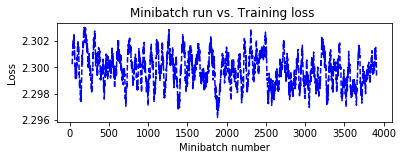

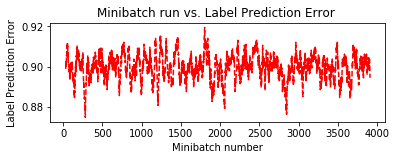

In [31]:
pred = train_and_evaluate(reader_train, 
                          reader_test, 
                          max_epochs=5, 
                          model_func=create_basic_model)

Now that we have a trained model, let us classify the following image of a truck. We use PIL to read the image.

In [32]:
# Figure 6
Image(url="https://cntk.ai/jup/201/00014.png", width=64, height=64)

In [33]:
# Download a sample image 
# (this is 00014.png from test dataset)
# Any image of size 32,32 can be evaluated

url = "https://cntk.ai/jup/201/00014.png"
myimg = np.array(PIL.Image.open(urlopen(url)), dtype=np.float32)

During training we have subtracted the mean from the input images. Here we take an approximate value of the mean and subtract it from the image.

In [34]:
from pandas import DataFrame

def eval(pred_op, image_data):
    label_lookup = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    
    image_data = image_data.copy()
    
    image_mean = 133.0
    image_data -= image_mean
    image_data = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))
    
    result = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))
    
    # Return top 3 results:
    top_count = 3
    result_indices = (-np.array(result)).argsort()[:top_count]
    
    print("Top 3 predictions:")
    for i in range(top_count):
        print("\tLabel: {:10s}, confidence: {:.2f}%".format(label_lookup[result_indices[i]], result[result_indices[i]] * 100))

In [35]:
# Run the evaluation on the downloaded image
eval(pred, myimg)

Top 3 predictions:
	Label: automobile, confidence: 11.58%
	Label: cat       , confidence: 10.24%
	Label: airplane  , confidence: 10.16%


In [36]:
pred.save('model.cntk')